# COMPAS Dataset Experiment

We firstly import the numerical and graphical tools we need in this program

In [1]:
import os
import pickle
import sys
import numpy as np
import torch.optim as optim
sys.path.append("../")
import sys
import torch
import datetime
from helpers.metrics import compute_coverage_v_acc_curve
from networks.linear_net import LinearNet
import datetime
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import scipy
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Next, we import the COMPAS dataset class as well as baseline methods of learning.

In [2]:
from baselines.lce_surrogate import LceSurrogate  # Mozannar et al.
from baselines.mix_of_exps import MixtureOfExperts  # Madras et al.
from datasetsdefer.broward import BrowardDataset # Dataset

We further import our post-processing method from the package.

In [3]:
from Tabular import postprocess

Next, I define the following function for running the baselines.

In [4]:
def main():

    # check if there exists directory ../exp_data
    if not os.path.exists("./exp_data"):
        os.makedirs("./exp_data")
        os.makedirs("./exp_data/data")
        os.makedirs("./exp_data/plots")
        os.makedirs("./exp_data/models")

    else:
        if not os.path.exists("./exp_data/data"):
            os.makedirs("./exp_data/data")
        if not os.path.exists("./exp_data/plots"):
            os.makedirs("./exp_data/plots")
        if not os.path.exists("./exp_data/models"):    
            os.makedirs("./exp_data/models")

    date_now = datetime.datetime.now()
    date_now = date_now.strftime("%Y-%m-%d_%H%M%S")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_dir = './exp_data/data'
    optimizer = optim.AdamW
    scheduler = None
    lr = 0.01
    regularizer_space = np.linspace(-2, 2, 100)
    num_regs = np.shape(regularizer_space)[0]
    print("num_regs: "+str(num_regs))
    max_trials = np.shape(regularizer_space)[0] * 10 # Here we have the number of iterations
    # this is for thresholding
    threshold_space = []
    for i in range(num_regs):
        threshold_space.append(np.random.rand(2, 3)*0.05)
    total_epochs = 500  # 100
    errors_lce = []
    errors_mixofexps = []
    for trial in range(max_trials):
        print("Trial: ", trial)
        # generate data
        dataset = BrowardDataset(data_dir, test_split=0.2, val_split=0.1)
        reg_coeff = regularizer_space[int(trial % num_regs)]
        model = LinearNet(dataset.d, 3).to(device)
        mixofexps = MixtureOfExperts(model, device, reg_coeff=reg_coeff)
        mixofexps.fit(
            dataset.data_train_loader,
            dataset.data_val_loader,
            dataset.data_test_loader,
            epochs=total_epochs,
            optimizer=optimizer,
            scheduler=scheduler,
            lr=lr,
            verbose=False,
            test_interval=5,
        )
        mixofexps_metrics = compute_coverage_v_acc_curve(
            mixofexps.test(dataset.data_test_loader)
        )
        # print("mixofexps_metrics: ", mixofexps_metrics)

        if trial % num_regs == 0:
            model = LinearNet(dataset.d, 3).to(device)
            LCE = LceSurrogate(1, 300, model, device)
            LCE.fit_hyperparam(
                dataset.data_train_loader,
                dataset.data_val_loader,
                dataset.data_test_loader,
                epochs=total_epochs,
                optimizer=optimizer,
                scheduler=scheduler,
                lr=lr,
                verbose=False,
                test_interval=5,
            )

        LCE.threshs = threshold_space[int(trial % num_regs)]
        lce_metrics = compute_coverage_v_acc_curve(
            LCE.test(dataset.data_test_loader))
        errors_mixofexps.append(mixofexps_metrics)
        errors_lce.append(lce_metrics)

    all_data = {
        "max_trials": max_trials,
        "mixofexp": errors_mixofexps,
        "num_regs": num_regs,
        "lce": errors_lce,
    }
    # dump data into pickle file
    with open("./exp_data/data/compass_exp_" + date_now + ".pkl", "wb") as f:
        pickle.dump(all_data, f)
    plot()

The following function is defined to find the pareto set of points in a dataset. We will use this in the plotted figure.

In [5]:
def pareto(X, Y):
    # First find the vertices of convex hull
    convex_hull = scipy.spatial.ConvexHull(np.array([X, Y]).T)
    convex_hull_vertices = convex_hull.vertices
    X = X[convex_hull_vertices]
    Y = Y[convex_hull_vertices]
    # if there are both Xs that are more than the current point and Ys that are less, then it is not pareto optimal
    # so, I remove them
    pareto_X = []
    pareto_Y = []
    for i in range(len(X)):
        is_pareto = True
        for j in range(len(X)):
            if X[j] > X[i] and Y[j] < Y[i]:
                is_pareto = False
                break
        if is_pareto:
            pareto_X.append(X[i])
            pareto_Y.append(Y[i])
    # sort the pareto front
    pareto_X, pareto_Y = zip(*sorted(zip(pareto_X, pareto_Y)))
    # append (0.6, x[0]) for the first (x[0], y[0]) point
    new_point = (0.6, pareto_Y[0])
    new_point_2 = (pareto_X[-1], 0.37)
    pareto_X = [new_point[0]] + list(pareto_X) + [new_point_2[0]]
    pareto_Y = [new_point[1]] + list(pareto_Y) + [new_point_2[1]]
    return pareto_X, pareto_Y


The following function runs the post-processing algorithm and plots the difference with the baselines.

In [6]:
def plot():
    # printing from a pickle file
    # find the only pickle file in the directory "../exp_data/data/"
    data_file_path1 = "./exp_data/data/" + [
        f for f in os.listdir("./exp_data/data/") if f.endswith(".pkl")
    ][0]
    with open(data_file_path1, 'rb') as f:
        data_results = pickle.load(f)

    metric = "system_acc"
    # extract date from file_path
    date_now = data_file_path1.split("/")[-1].split(".")[0][-17:]
    errors_mixofexps = data_results["mixofexp"]
    errors_lce = data_results["lce"]
    max_trials = data_results["max_trials"]
    num_regs = data_results["num_regs"]
    num_trials = int(max_trials / num_regs)
    print("max_trials: ", max_trials)
    print("num_regs: ", num_regs)
    print("num_trials: ", num_trials)

    # plot
    alpha_overlap = 0.2
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    rands = np.average([[errors_mixofexps[i+j*num_regs][0][metric] for i in
                         range(num_regs)] for j in range(num_trials)], axis=0)
    rands_lce = np.average([[errors_lce[i+j*num_regs][0][metric] for i in
                             range(num_regs)] for j in range(num_trials)],
                           axis=0)
    covs = np.average([[errors_mixofexps[i+j*num_regs][0]['coverage'] for i in
                        range(num_regs)] for j in range(num_trials)], axis=0)
    covs_lce = np.average([[errors_lce[i+j*num_regs][0]['coverage'] for i in
                            range(num_regs)] for j in range(num_trials)],
                          axis=0)
    DPs = np.average([[errors_mixofexps[i+j*num_regs][0]['DP'] for i in
                       range(num_regs)] for j in range(num_trials)], axis=0)
    DPs_lce = np.average([[errors_lce[i+j*num_regs][0]['DP'] for i in
                           range(num_regs)] for j in range(num_trials)],
                         axis=0)
    tols, max_loss, max_w, max_loss_std, max_w_std = postprocess()
    # scatter rands and covs
    plt.scatter(rands, np.abs(DPs), alpha=alpha_overlap, color="blue")
    plt.scatter(rands_lce, np.abs(DPs_lce), alpha=alpha_overlap, color="red")
    plt.scatter(max_loss, np.abs(max_w), alpha=alpha_overlap, color="green")
    rands, DPs = pareto(rands, np.abs(DPs))
    rands_lce, DPs_lce = pareto(rands_lce, np.abs(DPs_lce))
    max_loss, max_w = pareto(max_loss, np.abs(max_w))
    plt.plot(rands, DPs, color="blue", label='Madras et al. 2018')
    plt.plot(rands_lce, DPs_lce, color="red", label='Mozannar et al. 2020')
    plt.plot(max_loss, max_w, color="green", label='d-GNP')
    plt.legend(fontsize=11)
    # plot pareto front
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.grid()
    # plt.xlim(0.6, 0.75)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=15)
    plt.xlabel('Test Accuracy ', fontsize=20)
    plt.ylabel('Demographic Parity', fontsize=20)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 6
    fig_size[1] = 4.2
    plt.show()
    plt.savefig('./exp_data/plots/final_compass-'+date_now+'.pdf',
                bbox_inches='tight')



Now, we can run the whole program as following:

num_regs: 100
max_trials:  1000
num_regs:  100
num_trials:  10


100%|██████████| 500/500 [00:05<00:00, 85.93it/s]


Threshold: 1
Threshold: 2
Threshold: 3
Threshold: 4
Threshold: 5
Threshold: 6
Threshold: 7
Threshold: 8
Threshold: 9
Threshold: 10
Threshold: 11
Threshold: 12
Threshold: 13
Threshold: 14
Threshold: 15
Threshold: 16
Threshold: 17
Threshold: 18
Threshold: 19
Threshold: 20
Threshold: 21
Threshold: 22
Threshold: 23
Threshold: 24
Threshold: 25
Threshold: 26
Threshold: 27
Threshold: 28
Threshold: 29
Threshold: 30
Threshold: 31
Threshold: 32
Threshold: 33
Threshold: 34
Threshold: 35
Threshold: 36
Threshold: 37
Threshold: 38
Threshold: 39
Threshold: 40
Threshold: 41
Threshold: 42
Threshold: 43
Threshold: 44
Threshold: 45
Threshold: 46
Threshold: 47
Threshold: 48
Threshold: 49
Threshold: 50
Threshold: 51
Threshold: 52
Threshold: 53
Threshold: 54
Threshold: 55
Threshold: 56
Threshold: 57
Threshold: 58
Threshold: 59
Threshold: 60
Threshold: 61
Threshold: 62
Threshold: 63
Threshold: 64
Threshold: 65
Threshold: 66
Threshold: 67
Threshold: 68
Threshold: 69
Threshold: 70
Threshold: 71
Threshold: 72
T

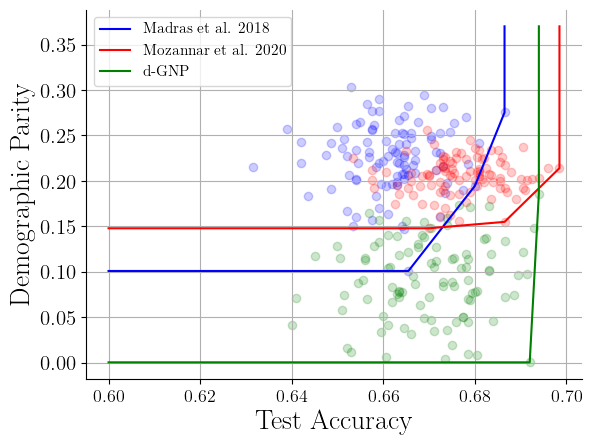

<Figure size 600x420 with 0 Axes>

In [7]:
main()